In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from time import time as timer

In [2]:
# Transmission Parameters - change values of beta and gamma for supplementary figures based on different 
# values of R0

beta = 2/7 # 3/7, 1.5/10
gamma = 1/7 # 1/7, 1/10 
Reff = beta/gamma # Effective reproduction number


omega = beta + gamma # Average lifetime of infectious case
r = beta - gamma # Growth rate 
rho = omega


ntime = 10000
Tmax = 1000
time = np.linspace(0, Tmax, ntime)
dtime = np.diff(time)[0]

# Initial conditions for probability of extinction and moment equations

q0 = 0
m0 = 1
m2_0 = 1

# Colour map

cmap = sns.color_palette("Set2")




Define offspring distribution for the branching process and then recover moments and probability of extinction, q(t), over time:

In [3]:
def Offspring(s):
    return 1/(omega) * ((beta * s**2) + gamma)

def q_deriv(u, t):
    return omega * (Offspring(u) - u)



u1 = omega*(1/omega * 2*beta - 1)

u2 = 2*beta 

def mean_deriv(u, t):
    return u1*u

def m2_deriv(u, t):
    return u2 * np.exp(2*u1*t) + u1 * u



q = sp.integrate.odeint(q_deriv, q0, time)

mean = (sp.integrate.odeint(mean_deriv, m0, time))

moment_2 = sp.integrate.odeint(m2_deriv, m2_0, time)

var = moment_2 - mean**2
q_grad = np.gradient(q.flatten(), dtime)
tstar_q = np.where(q_grad<=1e-3)[0][0]

var_coeff = np.sqrt(var)/(mean)
var_coeff_grad =  np.gradient(var_coeff.flatten(), dtime)
tstar_var_coeff = np.where(var_coeff_grad<=1e-3)[0][0]


/var/folders/dp/07jgbgpd0wqdpv18kyhd50vr0000gn/T/ipykernel_74387/3445174604.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(time, np.log(var ), label = "Variance", color = cmap[2])


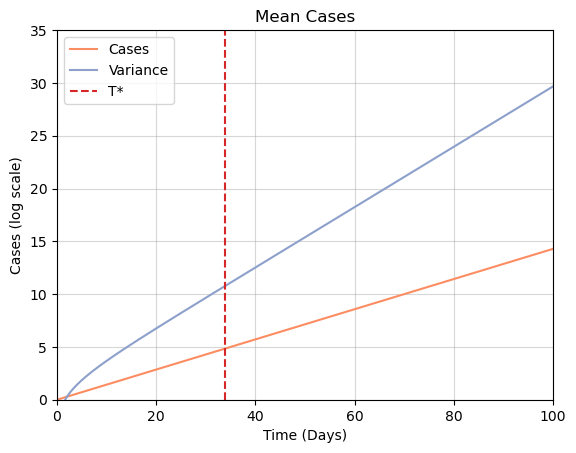

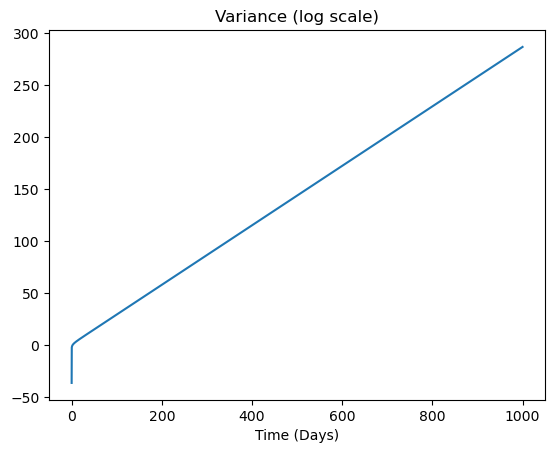

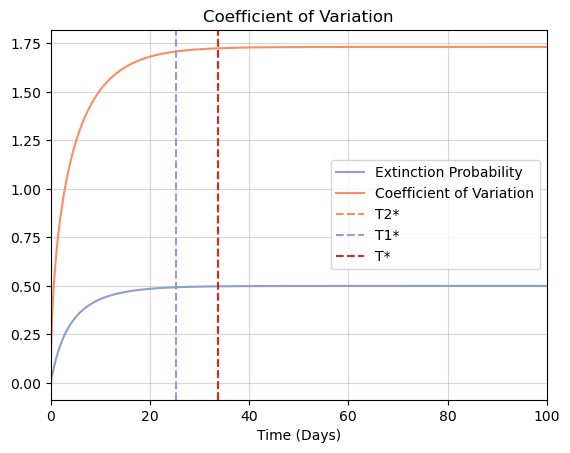

In [4]:

plt.figure(1)
plt.grid(alpha = 0.5)
plt.plot(time, np.log(mean), label = "Cases", color = cmap[1])
plt.plot(time, np.log(var ), label = "Variance", color = cmap[2])
plt.axvline(time[np.max((tstar_q, tstar_var_coeff))], color = 'tab:red', linestyle = '--', label = "T*")
plt.title("Mean Cases")
plt.xlim([0, 100])
plt.ylim([0, 35])
plt.xlabel("Time (Days)")
plt.ylabel("Cases (log scale)")
plt.legend()
# plt.savefig("mean_var_R=" + str(int(Reff)) + ".pdf")



plt.figure(2)
plt.plot(time, np.log(var + np.finfo(float).eps))
plt.title("Variance (log scale)")
plt.xlabel("Time (Days)")



plt.figure(3)
plt.plot(time, q, label = "Extinction Probability", color = cmap[2])
plt.plot(time, var_coeff, label = "Coefficient of Variation", color = cmap[1])
plt.grid(alpha = 0.5)
plt.axvline(time[tstar_var_coeff], color = cmap[1], linestyle = '--', label = "T2*")
plt.axvline(time[tstar_q], color = cmap[2], linestyle = '--', label = "T1*")
plt.axvline(time[np.max((tstar_q, tstar_var_coeff))] , color = 'tab:red', linestyle = '--', label = "T*")
plt.title("Coefficient of Variation")
plt.xlabel("Time (Days)")
plt.xlim([0, 100])
plt.legend()
plt.savefig("Tstar_choice_R=" + str(int(Reff)) + ".pdf")

Define $T^*$ and, hence, $Z^*$ based on different values of $\epsilon$ for the extinction probability and coefficient of variation:

In [5]:
u1 = beta - gamma
omega = beta + gamma



epsilons = 1e-5 * np.array((0.5e4, 1e3, 0.5e3, 1e2, 0.5e2, 1e1, 0.5e1, 1, 0.5))
tstar_qs_list = [np.where(q_grad<=thresh)[0][0] for thresh in epsilons]
tstar_qs = np.array(tstar_qs_list)
tstar_var_coeffs_list = [np.where(var_coeff_grad<=thresh)[0][0] for thresh in epsilons]
tstar_var_coeffs = np.array(tstar_var_coeffs_list)
tstar_idxs = np.maximum(tstar_qs, tstar_var_coeffs)


stop_cases = mean[tstar_idxs]#/q[tstar_idxs]
stop_cases_sqrt = [np.sqrt(im) for im in stop_cases]
cols = [str(int(label)) for label in stop_cases]
cols_sqrt = [str(int(label)) for label in stop_cases_sqrt]


stop_cases_idx = 3 # Index corresponding to baseline \epsilon = 10^{-3}
st_idx = stop_cases_idx
tstar_idx = tstar_idxs[stop_cases_idx]
Imax_feller = stop_cases[stop_cases_idx][0]
Imax = np.sqrt(Imax_feller)

In [6]:
Imax_feller # Z^* for baseline \epsilon= 10^{-3}

125.09261928195107

In [7]:

def gp_mu(u, t):
    return (u1)/2 * u

def gp_sigma(u, t):
    return np.sqrt(omega)/2

def gp_var(u, t):
    return (u1)*u + (omega/4)

def dW(t):
    return np.random.normal(loc = 0.0, scale = np.sqrt(t))


# Unapproximated Feller Diffusion

def feller_mu(u, t):
    return (beta - gamma) * u 

def feller_sigma(u, t):
    return np.sqrt(omega * u)

def feller_sigma_theory(u, t):
    return 2*u1*u + omega


y0 = 1
t0 = 0
dt = np.diff(time)[0]




In [10]:
nsims = 10000
start_x = 40
start_xs = [20, 40, 60, 80, 100]
stop_times_ics = np.zeros((nsims, len(start_xs)))
def gillespie(beta, gamma, y0, Tmax = Tmax, nevents = int(1e6), stop = [Imax_feller]):
    omega = beta + gamma
    t = 0
    rands = np.random.random(2*nevents).reshape((nevents, 2))
    cases = np.nan * np.ones(nevents)
    cases[0] = y0
    checks = 0
    stop_times = []
    for e in range(1, nevents):
        rate_vec = np.array((beta*cases[e-1], gamma*cases[e-1]))
        rate_sum = np.sum(rate_vec)

        rate_cumsum = np.cumsum(rate_vec)
        dt = -np.log(rands[e, 0])/rate_sum
        t += dt
        event_rand = rate_sum * rands[e, 1]
        event = np.where(rate_cumsum > event_rand)[0][0]
        if event ==0:
            cases[e] = cases[e-1] + 1
        elif event == 1:
            cases[e] = cases[e-1] - 1
        if cases[e] >= stop[checks]:
            cases[(e+1):] = cases[e]
            stop_times.append(t)
            checks +=1
            if checks == len(stop):
                break
        elif cases[e] == 0:
            stop_times = [np.nan for i in range(len(stop))]
            cases[(e+1):] = 0
            break
    if len(stop_times)<len(stop):
        stop_times_append = len(stop) - len(stop_times)
        stop_times_nans = [np.nan for i in range(stop_times_append)]
        stop_times += stop_times_nans
    return stop_times, cases


for sx, start_x in enumerate(start_xs):
    for i in tqdm(range(nsims)):
        stop_time_ics, gillespie_sim = gillespie(beta, gamma, start_x)
        stop_times_ics[i, sx] = stop_time_ics[0]


100%|████████████████████████████████████| 10000/10000 [01:26<00:00, 115.74it/s]


In [47]:
# Integer time points - produces fewer nans
time_coarse = np.arange(0, 125).astype(float)

# Increasing number of time points introduces nans for low T - need to deal with these
time_coarse = np.linspace(0, 125, 10000)

# One cdf for each initial condition, up to Z*
chisq_cdfs = [0 for x in range(int(Imax_feller))]

# Specify initial conditions as x0
def chi_sq(x, t, x0 = 1):
    
    x_scale = 2*r*x/(((rho/2))*(np.exp(r*t) - 1))
    
    lamb = 2*r*x0*np.exp(r*t)/((rho/2)*(np.exp(r*t) - 1))
    
    chi_sq_pdf = r/((rho/2)*(np.exp(r*t) - 1)) * np.sqrt(np.exp(r*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))

    return chi_sq_pdf


for i in tqdm(range(len(chisq_cdfs))):
    
    start_x = i+1
    cdf_chisq_new_ics = np.zeros_like(time_coarse)
    
    for T_idx in range(len(time_coarse)):

        T = time_coarse[T_idx]
        
        # Integrate the pdf up to Z*
        chi_sq_integral_new_ics = sp.integrate.quad(chi_sq, 0,
                                        int(Imax_feller), args = (T, start_x))[0]
        
        # New probability
        prob_new_ics =  (1-(chi_sq_integral_new_ics))
        

        #prob_new_ics =  (1-(chi_sq_integral_new_ics/full_int))
        cdf_chisq_new_ics[T_idx] = prob_new_ics

    neg_cdf = (1-cdf_chisq_new_ics)
    # Deal with nans here, but need to convert some infs to nans first 
    if np.isnan(neg_cdf[1]):
        neg_cdf[neg_cdf == np.inf] = np.nan
        
        # Conditioning
        cdf_chisq_new_ics = 1 - neg_cdf/np.max(neg_cdf[~np.isnan(neg_cdf)])
    # If nans not an issue    
    else:
        cdf_chisq_new_ics = 1 - neg_cdf/neg_cdf[1]
    
    
    chisq_cdfs[i] = cdf_chisq_new_ics

    
    
    

  0%|                                                   | 0/125 [00:00<?, ?it/s]/var/folders/dp/07jgbgpd0wqdpv18kyhd50vr0000gn/T/ipykernel_74387/3935805823.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  x_scale = 2*r*x/(((rho/2))*(np.exp(r*t) - 1))
/var/folders/dp/07jgbgpd0wqdpv18kyhd50vr0000gn/T/ipykernel_74387/3935805823.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  lamb = 2*r*x0*np.exp(r*t)/((rho/2)*(np.exp(r*t) - 1))
/var/folders/dp/07jgbgpd0wqdpv18kyhd50vr0000gn/T/ipykernel_74387/3935805823.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  chi_sq_pdf = r/((rho/2)*(np.exp(r*t) - 1)) * np.sqrt(np.exp(r*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))
/var/folders/dp/07jgbgpd0wqdpv18kyhd50vr0000gn/T/ipykernel_74387/3935805823.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  chi_sq_pdf = r/((rho/2)*(np.exp(r*t) - 1)) * np.sqrt(np.exp(r*t)/x) * 

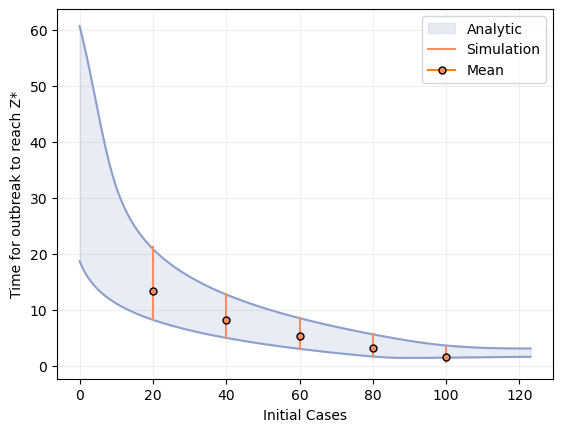

In [48]:
lq_cutoff = 0.01
uq_cutoff = 0.99
tlqs = [time_coarse[np.max(np.argwhere(cdf <= lq_cutoff))] for cdf in chisq_cdfs[:-1]]
ulqs = [time_coarse[np.min(np.argwhere(cdf >= uq_cutoff))] for cdf in chisq_cdfs[:-1]]


plt.grid(alpha = 0.2)
plt.plot(np.arange(0, 124), tlqs, color = cmap[2])
plt.plot(np.arange(0, 124), ulqs, color = cmap[2])
plt.fill_between(np.arange(0, 124), tlqs, ulqs, alpha = 0.2, color = cmap[2], label = 'Analytic')


for sx, start_x in enumerate(start_xs):
    if sx ==1:
        plt.plot((start_x,start_x), 
                 (np.quantile(stop_times_ics[:, sx], 0.01), np.quantile(stop_times_ics[:, sx], 0.99)),
                 c=cmap[1], 
                label = 'Simulation')
        plt.plot(start_x, 
                 np.mean(stop_times_ics[:, sx]), 
                 marker="o", 
                 markersize=5, 
                 markeredgecolor="black", 
                 markerfacecolor=cmap[1], 
                label = 'Mean')
    else:
        plt.plot((start_x,start_x), 
                 (np.quantile(stop_times_ics[:, sx], 0.01), np.quantile(stop_times_ics[:, sx], 0.99)),
                 c=cmap[1])
    
        plt.plot(start_x, 
                 np.mean(stop_times_ics[:, sx]), 
                 marker="o", 
                 markersize=5, 
                 markeredgecolor="black", 
                 markerfacecolor=cmap[1])

plt.xlabel('Initial Cases')
plt.ylabel('Time for outbreak to reach Z*')

plt.legend()
#plt.savefig('Sensitivity_to_initial_cases.pdf')

array([125.09261928])

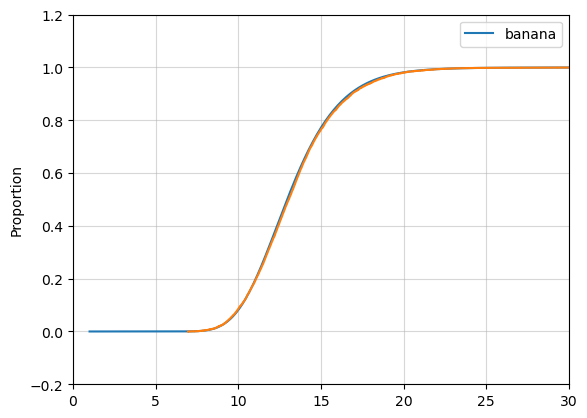

In [42]:
plt.grid(alpha = 0.5)
#plt.plot(time, cdf_chisq)
#plt.plot(time_coarse, 1-(boop/boop[1]), label = 'banana')
plt.plot(time_coarse+2*np.diff(time_coarse)[0], chisq_cdfs[20], label = 'banana')
#plt.plot(time, cdfs_ics[0], label = 'oops')
#plt.plot(time, cdfs_ics[1])

plt.legend()
plt.xlim([0, 30])
plt.ylim([-0.2, 1.2])
sns.ecdfplot(stop_times_ics[:, 0])
stop_cases[st_idx]


In [452]:
t1_new_ics = time[np.min(np.argwhere(cdf_chisq_new_ics >=0.05))]
t2_new_ics = time[np.min(np.argwhere(cdf_chisq_new_ics >=0.95))]

t1_old_ics = time[np.min(np.argwhere(cdf_chisq >=0.05))]
t2_old_ics = time[np.min(np.argwhere(cdf_chisq >=0.95))]

tdiff_new = t2_new_ics - t1_new_ics
tdiff_old = t2_old_ics - t1_old_ics

tdiff_old - tdiff_new


[12.136195325066545]